# Prédiction d'un résultat

In [1]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt

import sklearn as sk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn import metrics

import seaborn as sn

import random


### Importation du csv. Par défaut, le fichier que l'on récupère provient de github, raw indique que ce ne sont que les données brutes, sans les balises html.

__Si jamais vous ne possédez pas internet, commentez le premier read_csv, et décommentez le second, en supposant que vous avez cloné le projet git en local__

In [2]:
data_result_match = pd.read_csv("https://raw.githubusercontent.com/Phignis/predict-women-soccer-results/main/src/ressources/data/woman_international_cup_results.csv", sep=",")
# data_result_match = pd.read_csv("ressources/data/woman_international_cup_results.csv", sep=",")

In [3]:
print(data_result_match.shape)

(4296, 9)


In [4]:
# print(data_result_match)
data_result_match.head(5)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1969-11-01,Italy,France,1,0,Euro,Novara,Italy,False
1,1969-11-01,Denmark,England,4,3,Euro,Aosta,Italy,True
2,1969-11-02,England,France,2,0,Euro,Turin,Italy,True
3,1969-11-02,Italy,Denmark,3,1,Euro,Turin,Italy,False
4,1975-08-25,Thailand,Australia,3,2,AFC Championship,Hong Kong,Hong Kong,True


> A présent, mettons en forme les données, afin qu'elles soient exploitables par skLearn. Le but est de transformer toutes données ayant un intêrêt en colonne d'entier. Nous allons donc modifier la colonne home_team, away_team, tournament et le couple home_team/away_team/neutral

In [5]:
""" On ajoute d'abord une colonne Win pour savoir quelle équipe a gagné. 
 0 égalité
 1 victoire home
 2 victoire away """

for index in data_result_match.index :
    if(data_result_match.loc[index, 'home_score'] == data_result_match.loc[index, 'away_score']) :
      data_result_match.loc[index, 'Win'] = 0
    elif(data_result_match.loc[index, 'home_score'] > data_result_match.loc[index, 'away_score']) :
      data_result_match.loc[index, 'Win'] = 1
    else :
      data_result_match.loc[index, 'Win'] = 2

data_result_match['Win'] = data_result_match['Win'].astype(int)


In [6]:
""" On ajoute une colonne id_away_team et id_home_team pour connaitre les équipes ayant joué, sous forme numérique pour traitement"""
liste_pays = sorted(list(set(np.concatenate([data_result_match['home_team'], data_result_match['away_team']]))))
"""
liste_pays contient ici un ensemble de tout les noms de home_teams et away_teams, de manière unique. On le stocke dans un set, 
pour garentir l'unicité de chaque équipe dans tout le match
"""

for index in data_result_match.index :
  data_result_match.loc[index, 'id_home_team']= liste_pays.index(data_result_match.loc[index, 'home_team'])
  data_result_match.loc[index, 'id_away_team']= liste_pays.index(data_result_match.loc[index, 'away_team'])

data_result_match['id_home_team'] = data_result_match['id_home_team'].astype(int) # pour avoir des entiers, par défaut c'étaient des floats
data_result_match['id_away_team'] = data_result_match['id_away_team'].astype(int) # pour avoir des entiers, par défaut c'étaient des floats

In [7]:
"""
Actuellement, les prédictions prennent entre autres id_home_team, id_away_team et neutral. Pourtant, en terme de prédiction, un France Italy sur terrain neutre et l'équivalent
d'un Italy France sur terrain neutre. Pourtant actuellement, nos modèles ne peuvent le prendre en compte. Pour éviter cela, le but est de générer un id unique, en fonction de la situation.
Les deux situations citées précédemment possèderaient donc le même id, tandis que les mêmes équipes sur terrain non neutre deviendrait un id différent.
L'implémentation choisie est d'effectuer un dictionnaire, avec pour clé le tuple (id_team_1, id_team_2, terrain_neutre), et en value son id Unique, auto-incrémenté
"""

# on commence par récupéré toute la liste des équipes de notre dataset, pour pouvoir générer tout les tuples possibles, on l'a déjà calculé, c'est listePays
liste_tuple = [0] * pow(len(liste_pays), 2)
i = 0
for tuple_1 in liste_pays:
  for tuple_2 in liste_pays:
    liste_tuple[i] = (tuple_1, tuple_2)
    i += 1
# on a généré tout les tuples possibles, y compris les (i, i), les (i, j) et (j, i). On ne veut pas les (i, i), on va directement les supprimer
liste_tuple = [tuple_i_j for tuple_i_j in liste_tuple if tuple_i_j[0] != tuple_i_j[1]]

etat_match_id = dict()
i = 0
# il reste a les rentrer dans le dictionnaire
for current_tuple in liste_tuple:
  etat_match_id[current_tuple + (True, )] = i
  i += 1
  etat_match_id[current_tuple + (False, )] = i
  i += 1

# il reste un soucis, on veut que (i, j, true) et (j, i, true) ait le même id, ce qui n'est pas le cas actuellement. Le but est donc de tout bien remettre en place
for current_tuple in etat_match_id:
  if(current_tuple[2] is True):
    # alors pour (i, j, true), il existe forcément (j, i, true)
    etat_match_id[(current_tuple[1], current_tuple[0], current_tuple[2])] = etat_match_id[current_tuple]


# notre dictionnaire est prêt, reste a générer la nouvelle colonne, nommé etat_match
for index in data_result_match.index :
  data_result_match.loc[index, 'etat_match'] = etat_match_id[(data_result_match.loc[index, 'home_team'], data_result_match.loc[index, 'away_team'], data_result_match.loc[index, 'neutral'])]
data_result_match['etat_match'] = data_result_match['etat_match'].astype(int)

In [8]:
""" On ajoute une colonne id_tournoi pour connaitre les tournois, sous forme numérique pour traitement"""

liste_tournois = sorted(list(pd.unique(data_result_match['tournament'])))
for index in data_result_match.index :
  data_result_match.loc[index, 'id_tournoi'] = liste_tournois.index(data_result_match.loc[index, 'tournament'])
data_result_match['id_tournoi'] = data_result_match['id_tournoi'].astype(int)

In [9]:
"""On affiche le DataFrame pour savoir à quoi il ressemble"""

data_result_match.head(10)

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,Win,id_home_team,id_away_team,etat_match,id_tournoi
0,1969-11-01,Italy,France,1,0,Euro,Novara,Italy,False,1,90,64,34509,13
1,1969-11-01,Denmark,England,4,3,Euro,Aosta,Italy,True,1,47,54,18060,13
2,1969-11-02,England,France,2,0,Euro,Turin,Italy,True,1,54,64,20754,13
3,1969-11-02,Italy,Denmark,3,1,Euro,Turin,Italy,False,1,90,47,34475,13
4,1975-08-25,Thailand,Australia,3,2,AFC Championship,Hong Kong,Hong Kong,True,1,170,10,4158,2
5,1975-08-25,Hong Kong,New Zealand,0,2,AFC Championship,Hong Kong,Hong Kong,False,2,80,125,30809,2
6,1975-08-27,Thailand,Singapore,3,0,AFC Championship,Hong Kong,Hong Kong,True,1,170,154,59166,2
7,1975-08-27,New Zealand,Malaysia,3,0,AFC Championship,Hong Kong,Hong Kong,True,1,125,108,41504,2
8,1975-08-29,Australia,Singapore,3,0,AFC Championship,Hong Kong,Hong Kong,True,1,10,154,4126,2
9,1975-08-29,Hong Kong,Malaysia,0,2,AFC Championship,Hong Kong,Hong Kong,False,2,80,108,30775,2


>
> On étudie la corrélation entre notre champ Win et les autres colonnes du dataset
>

home_score     -0.237448
away_score      0.529250
neutral        -0.033951
Win             1.000000
id_home_team    0.004386
id_away_team    0.026386
etat_match      0.026048
id_tournoi      0.027258
Name: Win, dtype: float64


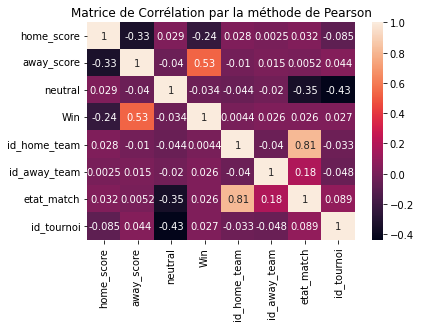

In [10]:
""" Nous créons ici la matrice de correlation correspondant aux données de notre dataFrame """
matrice_correlation_pearson = data_result_match.corr('pearson')
print(matrice_correlation_pearson['Win'])


"""Ici nous visualisons les données de la matrice de corrélation pour ensuite interpréter ces résultats"""
sn.heatmap(matrice_correlation_pearson, annot=True)

plt.title("Matrice de Corrélation par la méthode de Pearson")
plt.show()

home_score     -0.416591
away_score      0.602136
neutral        -0.038232
Win             1.000000
id_home_team   -0.002218
id_away_team    0.028094
etat_match      0.027464
id_tournoi      0.036868
Name: Win, dtype: float64


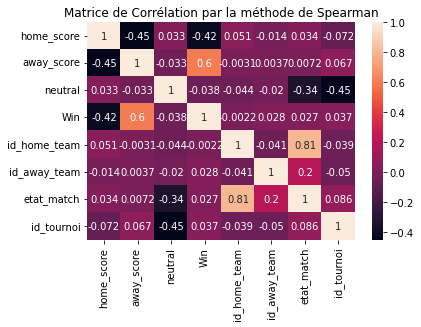

In [11]:
""" Nous créons ici la matrice de correlation correspondant aux données de notre dataFrame """
matrice_correlation_spearman = data_result_match.corr('spearman')
print(matrice_correlation_spearman['Win'])


"""Ici nous visualisons les données de la matrice de corrélation pour ensuite interpréter ces résultats"""
sn.heatmap(matrice_correlation_spearman, annot=True)

plt.title("Matrice de Corrélation par la méthode de Spearman")
plt.show()

home_score     -0.337634
away_score      0.509863
neutral        -0.036626
Win             1.000000
id_home_team   -0.001821
id_away_team    0.022006
etat_match      0.021519
id_tournoi      0.029887
Name: Win, dtype: float64


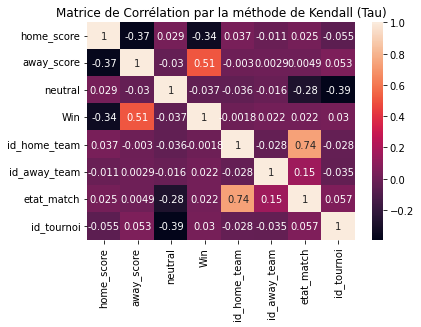

In [12]:
""" Nous créons ici la matrice de correlation correspondant aux données de notre dataFrame """
matrice_correlation_kendall = data_result_match.corr('kendall')
print(matrice_correlation_kendall['Win'])


"""Ici nous visualisons les données de la matrice de corrélation pour ensuite interpréter ces résultats"""
sn.heatmap(matrice_correlation_kendall, annot=True)

plt.title("Matrice de Corrélation par la méthode de Kendall (Tau)")
plt.show()

> Entrainement du modèle, séparation du jeu de test et d'entrainement en utilisant les colonnes 'id_home_team', 'id_away_team' et 'neutral'.

In [13]:
""" Ici nous choisissons d'utiliser 75% du dataset pour entraîner le modèle et 25% pour effectuer nos tests."""
x_train, x_test, y_train, y_test = train_test_split(data_result_match[[ 'id_home_team', 'id_away_team','neutral']], 
                                                    data_result_match['Win'], test_size = 0.25, random_state = 0)


In [14]:
""" Nous entrainons le modèle en utilisant la méthode de classification avec l'arbre de décision"""

arbre_decision = DecisionTreeClassifier(random_state = 0, max_depth = 20)
clf = arbre_decision.fit(x_train, y_train)

In [15]:
""" Nous effectuons notre classification sur notre jeu de test en utilisant le modèle entrainé avec la méthode de classification avecc l'arbre de décision """

sPredict = clf.predict(x_test)

scoreArbre1 = accuracy_score(y_test, sPredict)

print(scoreArbre1)

0.5726256983240223


In [16]:
""" Nous entrainons le modèle en utilisant la méthode de classification avec le plus proche voisin """

KNN = KNeighborsClassifier()
clf = KNN.fit(x_train, y_train)


In [17]:
""" Nous effectuons notre classification sur notre jeu de test en utilisant le modèle entrainé avec la méthode de classification avec le plus proche de voisin """

sPredict = clf.predict(x_test)

scoreKNN1 = accuracy_score(y_test, sPredict);
print(scoreKNN1)


0.5558659217877095


In [18]:

""" Nous entrainons le modèle en utilisant la méthode de classification avec SVM """
clf = svm.SVC(gamma = 0.001)
clf.fit(x_train, y_train)


SVC(gamma=0.001)

In [19]:
""" Nous effectuons notre classification sur notre jeu de test en utilisant le modèle entrainé avec la méthode de classification avec SVM """

sPredict = clf.predict(x_test)

scoreSVM1 = accuracy_score(y_test, sPredict);
print(scoreSVM1)

0.5344506517690876


> Entrainement du modèle, séparation du jeu de test et d'entrainement en utilisant les colonnes 'id_home_team', 'id_away_team' et 'etat_match'.

In [20]:
""" Ici nous choisissons d'utiliser 75% du dataset pour entraîner le modèle et 25% pour effectuer nos tests."""
x_train, x_test, y_train, y_test = train_test_split(data_result_match[[ 'id_home_team', 'id_away_team','etat_match']], 
                                                    data_result_match['Win'], test_size = 0.25, random_state = 0)


In [21]:
""" Nous entrainons le modèle en utilisant la méthode de classification avec l'arbre de décision"""

arbre_decision = DecisionTreeClassifier(random_state = 0, max_depth = 20)
clf = arbre_decision.fit(x_train, y_train)




In [22]:
""" Nous effectuons notre classification sur notre jeu de test en utilisant le modèle entrainé avec la méthode de classification avecc l'arbre de décision """

sPredict = clf.predict(x_test)

scoreArbre2 = accuracy_score(y_test, sPredict)

print(scoreArbre2)

0.5633147113594041


In [23]:
""" Nous entrainons le modèle en utilisant la méthode de classification avec le plus proche voisin """

KNN = KNeighborsClassifier()
clf = KNN.fit(x_train, y_train)


In [24]:
""" Nous effectuons notre classification sur notre jeu de test en utilisant le modèle entrainé avec la méthode de classification avec le plus proche de voisin """

sPredict = clf.predict(x_test)

scoreKNN2 = accuracy_score(y_test, sPredict);
print(scoreKNN2)


0.5335195530726257


In [25]:

""" Nous entrainons le modèle en utilisant la méthode de classification avec SVM """
clf = svm.SVC(gamma = 0.001)
clf.fit(x_train, y_train)


SVC(gamma=0.001)

In [26]:
""" Nous effectuons notre classification sur notre jeu de test en utilisant le modèle entrainé avec la méthode de classification avec SVM """

sPredict = clf.predict(x_test)

scoreSVM2 = accuracy_score(y_test, sPredict);
print(scoreSVM2)

0.5884543761638734


> Entrainement du modèle, séparation du jeu de test et d'entrainement en utilisant les colonnes 'id_home_team', 'id_away_team, 'etat_match' et 'id_tournois'.

In [27]:
""" Ici nous choisissons d'utiliser 75% du dataset pour entraîner le modèle et 25% pour effectuer nos tests."""
x_train, x_test, y_train, y_test = train_test_split(data_result_match[[ 'id_home_team', 'id_away_team','etat_match', 'id_tournoi']], 
                                                    data_result_match['Win'], test_size = 0.25, random_state = 0)


In [28]:
""" Nous entrainons le modèle en utilisant la méthode de classification avec l'arbre de décision"""

arbre_decision = DecisionTreeClassifier(random_state = 0, max_depth = 20)
clf = arbre_decision.fit(x_train, y_train)




In [29]:
""" Nous effectuons notre classification sur notre jeu de test en utilisant le modèle entrainé avec 
la méthode de classification avecc l'arbre de décision """

sPredict = clf.predict(x_test)

scoreArbre3 = accuracy_score(y_test, sPredict)

print(scoreArbre3)

0.5819366852886406


In [30]:
""" Nous entrainons le modèle en utilisant la méthode de classification avec le plus proche voisin """

KNN = KNeighborsClassifier()
clf = KNN.fit(x_train, y_train)


In [31]:
""" Nous effectuons notre classification sur notre jeu de test en utilisant le modèle entrainé avec 
la méthode de classification avec le plus proche de voisin """

sPredict = clf.predict(x_test)

scoreKNN3 = accuracy_score(y_test, sPredict);
print(scoreKNN3)


0.5400372439478585


In [32]:

""" Nous entrainons le modèle en utilisant la méthode de classification avec SVM """
clf = svm.SVC(gamma = 0.001)
clf.fit(x_train, y_train)


SVC(gamma=0.001)

In [33]:
""" Nous effectuons notre classification sur notre jeu de test en utilisant le modèle entrainé avec 
la méthode de classification avec SVM """

sPredict = clf.predict(x_test)

scoreSVM3 = accuracy_score(y_test, sPredict);
print(scoreSVM3)

0.5921787709497207


In [34]:
""" Nous pouvons faire varier le paramètre C et Gamma de SVM, pour pouvoir faire varier l'accuracy, et l'optimiser"""
print(classification_report(y_test, sPredict))

              precision    recall  f1-score   support

           0       0.18      0.03      0.06       150
           1       0.61      0.84      0.71       574
           2       0.57      0.43      0.49       350

    accuracy                           0.59      1074
   macro avg       0.45      0.43      0.42      1074
weighted avg       0.54      0.59      0.55      1074



In [35]:
""" On peut voir que l'accuracy de fi-scorre est à 0.59, voyons si l'on peut trouver de meilleurs paramètres """
param_grid = {'C':[1,10,100,1000],'gamma':[1,0.1,0.001,0.0001], 'kernel':['linear','rbf']} # dictio des C, gamma et kernel a tester

grid = GridSearchCV(svm.SVC(), param_grid, n_jobs = -1, verbose = 3)  # va permettre de tester tout les paramètres possibles

# grid.fit(x_train, y_train) # lance le test
"""Surcharge le notebook, a ne pas décommenter """

'Surcharge le notebook, a ne pas décommenter '

In [36]:
"""
On vérifie si un random ne permet pas d'avoir de meilleurs résultats
"""

liste_test = []
max_score_test = 0
for i in range(150) :
  for i in range(len(y_test)) :
    liste_test.append(random.randint(0,2))
  score_test = accuracy_score(y_test, liste_test)
  if score_test > max_score_test :
    max_score_test = score_test
  liste_test = []
print(max_score_test)

0.37337057728119183
